<a href="https://colab.research.google.com/github/yin-penghang/AMAT593/blob/main/18_Applications_III/02_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Collaborative Filtering Recommendation Systems

[Collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) aims to fill in the missing entries of a user-item rating matrix with predicted ratings, so that users are recomended new items based on the predicted ratings. 

In this notebook, we will introduce the classical matrix factorization model for collaborative filtering as well as the state-of-the-arts based on neural networks.


<img src="https://github.com/yin-penghang/AMAT593/blob/main/figs/15_CF.png?raw=true" width = '400'>

# Matrix Factorization

Collaborative filtering is an application of matrix factorization to identify the relationship between items’ and users’ entities. With the input of users’ ratings on some of the items, we would like to predict how the users would rate the other items so the users can get the recommendation based on the prediction.

Suppose we have the user-item rating matrix $\mathbf{R}\in\mathbb{R}^{m\times n}$ for $m$ users and $n$ items, and the ratings are integers ranging from 1 to 5:

<img src= 'https://github.com/yin-penghang/AMAT593/blob/main/figs/15_rating_matrix.png?raw=true' width = '800'>

The $(i,j)$-th entry $r_{i,j}$ represents the $i$-th user's rating on the $j$-th item.
The rating matrix $\mathbf{R}\in\mathbb{R}^{m\times n}$ has a large portion of entries/ratings missing, and our goal here is to impute the full matrix. 

Matrix factorization model assumes: every item has the same set of $k$ **latent factors** based on which a user will give the rating, where **$k$ is much less than the number of users and the number of items**. Maybe one factor means "movies with frantic chases", another factor might mean "movies with a plot twist", etc. 

Let $\mathbf{q}_j \in\mathbb{R}^k$ be the $j$-th item's **components** in the $k$ latent factors and $\mathbf{p}_i\in\mathbb{R}^k$ be the $i$-th user's **personal preferences** on these $k$ latent factors, e.g.,

    Movie j = 0.5 x frantic chases + 0.2 x plot twist + ...
    
    User i = 0.3 x fan of frantic chases + 1.8 x fan of plot twist + ...

In practice, the latent factors are opaque. Given $\mathbf{q}_j$ and $\mathbf{p}_i$, the model generates the rating:

$$
\hat{r}_{i,j} = \mathbf{p}_i^\top \mathbf{q}_j
$$

In matrix form, denote by $\mathbf{P} = \begin{bmatrix} | \qquad | \\ \mathbf{p}_1 \cdots \mathbf{p}_m \\ | \qquad | \end{bmatrix}\in\mathbb{R}^{k\times m}$ the user latent matrix, and $\mathbf{Q} = \begin{bmatrix} | \qquad | \\ \mathbf{q}_1 \cdots \mathbf{q}_n \\ | \qquad | \end{bmatrix}\in\mathbb{R}^{k\times n}$ the item latent matrix, then the predicted rating matrix has the **low-rank matrix factorization**

$$
\hat{\mathbf{R}} = \mathbf{P}^\top \, \mathbf{Q}\in\mathbb{R}^{m\times n}
$$

<img src='https://github.com/yin-penghang/AMAT593/blob/main/figs/15_MatFacto.png?raw=true' width = '500'>

For any observed rating $r_{i,j}\in\mathbf{R}$, $\hat{\mathbf{R}}$ satisfies 

$$
\hat{r}_{i,j} = \mathbf{p}_i^\top \mathbf{q}_j \approx r_{i,j}.
$$

**Under the constraints above, we aim to infer the user latent matrix $\mathbf{P}$ and item latent matrix $\mathbf{Q}$** by solving

$$
\min_{\{\mathbf{p}_i\}_{i=1}^m, \{\mathbf{q}_j\}_{j=1}^n} \; \sum_{\mbox{ observed } r_{i,j}} (r_{i,j} - \mathbf{p}_i^\top \mathbf{q}_j)^2
+ \lambda(\|\mathbf{p}_i\|^2 + \|\mathbf{q}_j\|^2)
$$

### The Algorithm

The minimization is performed by a straightforward mini-batch gradient descent: for an observed rating $r_{i,j}$, iterate

\begin{align}
\mathbf{p}_i \leftarrow \mathbf{p}_i - \eta  \left( (\mathbf{p}_i^\top \mathbf{q}_j - r_{i,j})\mathbf{q}_j + \lambda \mathbf{p}_i \right) \\
\mathbf{q}_j \leftarrow \mathbf{q}_j - \eta  \left( (\mathbf{p}_i^\top \mathbf{q}_j - r_{i,j})\mathbf{p}_i + \lambda \mathbf{q}_j \right)
\end{align}

The above iterations are known as the SVD algorithm, as popularized by [Simon Funk](https://sifter.org/~simon/journal/20061211.html) during the Netflix Prize, although 
**it is actually NOT [SVD](https://en.wikipedia.org/wiki/Singular_value_decomposition) which computes the factorization of a full matrix.** The more appropriate term for what Funk did is **matrix factorization**.

## Tensorflow Implementation

We implement matrix factorization model using the Tensorflow/Keras libraries. The key for the implementation is to represent the user latent matrix $P\in\mathbb{R}^{k\times m}$ and item latent matrix $Q\in\mathbb{R}^{k\times n}$ with two **Embedding** layers. With this notion, $P$ and $Q$ can be viewed as trainable weight matrices of the model.

In [2]:
import pandas as pd
import numpy as np
# import random

In [3]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras import regularizers
from keras.layers import Embedding, Flatten, Input, dot
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

In [50]:
def MatrixFacto(n_users, n_movies, latent_dim):
    
    movie_input = Input(shape=[1])
    movie_embedding = Embedding(input_dim = n_movies, output_dim = latent_dim, embeddings_regularizer=regularizers.L2(l2=1e-6))(movie_input)
    movie_vec = Flatten()(movie_embedding)

    user_input = Input(shape=[1])
    user_embedding = Embedding(input_dim = n_users, output_dim = latent_dim, embeddings_regularizer=regularizers.L2(l2=1e-6))(user_input)
    user_vec = Flatten()(user_embedding)

    dot_prod = dot([movie_vec, user_vec], axes=1)


    model = Model(inputs = [user_input, movie_input], outputs = dot_prod)
    model.compile(loss = 'mse', optimizer = 'adam', metrics = tf.keras.metrics.RootMeanSquaredError(name='rmse'))
  
    
    return model

### MovieLens Dataset

MovieLens small dataset contains ~100,000 ratings from ~600 users on ~9700 movies.

In [4]:
# Reading ratings file
data = pd.read_csv('ratings.csv', sep=',', encoding='latin-1', usecols=['userId','movieId','rating'])
data.head(10)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
5,1,70,3.0
6,1,101,5.0
7,1,110,4.0
8,1,151,5.0
9,1,157,5.0


In [119]:
print(data.movieId.unique())

[     1      3      6 ... 160836 163937 163981]


In [120]:
print(data.userId.unique())

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 242 243 244 245 246 24

Need to map movie IDs to `[0, n_movies-1]` and user IDs to `[0, n_user -1]`. Note that the movie IDs are not consecutive.

In [5]:
movie_id_to_new_id = dict()
id = 0
for index, row in data.iterrows():
    if movie_id_to_new_id.get(row['movieId']) is None:
        movie_id_to_new_id[row['movieId']] = id
        data.at[index, 'movieId'] = id
        id += 1
    else:
        data.at[index, 'movieId'] = movie_id_to_new_id.get(row['movieId'])

In [6]:
data.userId = data.userId-1

In [9]:
data.head(10)

,userId,movieId,rating
0,0,0,4.0
1,0,1,4.0
2,0,2,4.0
3,0,3,5.0
4,0,4,5.0
5,0,5,3.0
6,0,6,5.0
7,0,7,4.0
8,0,8,5.0
9,0,9,5.0


In [7]:
n_users = data.userId.unique().shape[0]
n_movies = data.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + '\nNumber of movies = ' + str(n_movies))

Number of users = 610
Number of movies = 9724


Let's first check the sparsity of the ratings dataset, i.e., the percentage of missing ratings:

In [8]:
sparsity = round(1.0 - len(data) / float(n_users * n_movies), 3)
print('The sparsity level of MovieLens dataset is ' +  str(sparsity * 100) + '%')

The sparsity level of MovieLens dataset is 98.3%


In [9]:
from sklearn.model_selection import train_test_split

In [56]:
train, test = train_test_split(data, test_size=0.2, random_state = 101)
X_tr, y_tr = [train.userId, train.movieId], train.rating
X_te, y_te = [test.userId, test.movieId], test.rating

Instantiate a ``MatrixFacto``  algorithm object with specified hyperparameters:

In [57]:
latent_dim = 10
MF_model = MatrixFacto(n_users, n_movies, latent_dim)
MF_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_14 (Embedding)       (None, 1, 10)        97240       ['input_15[0][0]']               
                                                                                                  
 embedding_15 (Embedding)       (None, 1, 10)        6100        ['input_16[0][0]']               
                                                                                            

Visualize the model architecture:

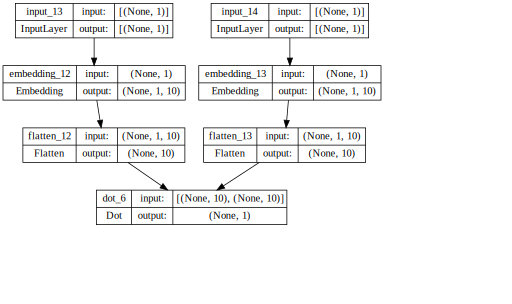

In [52]:
SVG(model_to_dot(MF_model, show_shapes=True).create(prog='dot', format='svg'))

In [53]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [58]:
path_checkpt = "MF_checkpt.h5"
es_callback = EarlyStopping(monitor="val_rmse", patience=5)

modelckpt_callback = ModelCheckpoint(
    monitor="val_rmse",
    filepath=path_checkpt,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [59]:
history = MF_model.fit(X_tr, y_tr, validation_data=(X_te, y_te), batch_size =128, epochs=40, callbacks=[es_callback, modelckpt_callback])  

Epoch 1/40
629/631 [============================>.] - ETA: 0s - loss: 13.1075 - rmse: 3.6204
Epoch 1: val_rmse improved from inf to 3.44313, saving model to MF_checkpt.h5
631/631 [==============================] - 3s 4ms/step - loss: 13.1037 - rmse: 3.6199 - val_loss: 11.8556 - val_rmse: 3.4431
Epoch 2/40
631/631 [==============================] - ETA: 0s - loss: 8.0344 - rmse: 2.8342
Epoch 2: val_rmse improved from 3.44313 to 2.23459, saving model to MF_checkpt.h5
631/631 [==============================] - 2s 4ms/step - loss: 8.0344 - rmse: 2.8342 - val_loss: 4.9966 - val_rmse: 2.2346
Epoch 3/40
629/631 [============================>.] - ETA: 0s - loss: 3.5575 - rmse: 1.8850
Epoch 3: val_rmse improved from 2.23459 to 1.72466, saving model to MF_checkpt.h5
631/631 [==============================] - 2s 4ms/step - loss: 3.5555 - rmse: 1.8844 - val_loss: 2.9800 - val_rmse: 1.7247
Epoch 4/40
631/631 [==============================] - ETA: 0s - loss: 2.2705 - rmse: 1.5047
Epoch 4: val_rmse 

### Model evaluation

Load the best validated model and check the validation error

In [60]:
MF_model.load_weights(path_checkpt)
MF_model.evaluate(X_te, y_te)

631/631 [==============================] - 2s 3ms/step - loss: 1.2054 - rmse: 1.0902


[1.205424189567566, 1.090185284614563]

### Prediction

In [61]:
df = test[test['userId'] == 0]
df

,userId,movieId,rating
204,0,204,4.0
215,0,215,5.0
83,0,83,3.0
71,0,71,5.0
131,0,131,4.0
178,0,178,5.0
16,0,16,3.0
225,0,225,5.0
170,0,170,2.0
5,0,5,3.0


In [62]:
df = df.sort_values(by = 'movieId')
df = df.reset_index(drop=True)
df

,userId,movieId,rating
0,0,0,4.0
1,0,1,4.0
2,0,2,4.0
3,0,5,3.0
4,0,14,4.0
5,0,16,3.0
6,0,18,5.0
7,0,31,5.0
8,0,39,3.0
9,0,42,3.0


Now let's predict the ratings that User with ID 0 will give to the movies from the test set.

In [63]:
pred = MF_model.predict([df.userId, df.movieId])
print(pred)

2/2 [==============================] - 0s 5ms/step
[[4.7571826]
 [4.111106 ]
 [4.8101764]
 [4.2549243]
 [4.3895006]
 [5.0271235]
 [4.602426 ]
 [4.6190805]
 [3.5785325]
 [4.026211 ]
 [5.032786 ]
 [5.172174 ]
 [4.37385  ]
 [4.126385 ]
 [4.472048 ]
 [5.0679126]
 [5.133504 ]
 [4.645711 ]
 [5.182828 ]
 [4.998328 ]
 [4.384294 ]
 [4.413248 ]
 [4.258197 ]
 [4.6035805]
 [3.9330184]
 [2.5365818]
 [3.7125988]
 [4.7507105]
 [4.6423526]
 [3.9366379]
 [4.328064 ]
 [3.916995 ]
 [4.1476483]
 [4.0071115]
 [4.497737 ]
 [4.868307 ]
 [5.0009713]
 [4.8982306]
 [4.6255493]
 [3.9098299]
 [4.0974646]
 [4.1134915]
 [4.5614443]
 [4.482579 ]
 [4.8252106]
 [4.2441025]
 [4.3370695]]


In [64]:
pd.DataFrame(pred, columns = ['rating'])

,rating
0,4.757183
1,4.111106
2,4.810176
3,4.254924
4,4.389501
5,5.027123
6,4.602426
7,4.619081
8,3.578532
9,4.026211


In [65]:
df_pred = pd.concat([df, pd.DataFrame(pred, columns = ['pred_rating'])], axis = 1)
df_pred

,userId,movieId,rating,pred_rating
0,0,0,4.0,4.757183
1,0,1,4.0,4.111106
2,0,2,4.0,4.810176
3,0,5,3.0,4.254924
4,0,14,4.0,4.389501
5,0,16,3.0,5.027123
6,0,18,5.0,4.602426
7,0,31,5.0,4.619081
8,0,39,3.0,3.578532
9,0,42,3.0,4.026211


# Neural Collaborative Filtering

In this section, we instroduce a new way to do collaborative filtering with deep learning techiniques. There's a paper from 2017, titled [Neural Collaborative Filtering](https://arxiv.org/pdf/1708.05031.pdf), which describes the approach to perform collaborative filtering using neural networks.


This a fused model with two major components that contribute to the predicted rating: matrix factorization and single-layer perceptron (a dense layer), whose outputs are combined through concatenation into the last hidden dense layer:

$$
\hat{r}_{i,j} = \sigma\left(v^\top \begin{bmatrix} p_{i}^\top q_{j} \\  \sigma\left(W\begin{bmatrix}p_{i}\\q_{j}\end{bmatrix}+ b\right)\end{bmatrix}+ c\right)
$$

where $\sigma$ is a nonlinear activation fuction, e.g. ReLU. 

For the impelementation, the latent user/item vectors $p_i$'s, $q_j$'s are trainable parameters from two Embedding layers. $W, v$ are the weights from dense layers, where as $b, c$ are the bias terms repectively.


In [13]:
from keras.layers import concatenate, Dense

In [14]:
def NeuralMatFacto(n_movie, n_user, latent_dim):
  # Define inputs
    movie_input = Input(shape=[1])
    user_input = Input(shape=[1])

    # Perceptron Embeddings
    movie_embedding_dense = Embedding(n_movies, latent_dim)(movie_input)
    movie_vec_dense = Flatten()(movie_embedding_dense)

    user_embedding_dense = Embedding(n_users, latent_dim)(user_input)
    user_vec_dense = Flatten()(user_embedding_dense)

   # MF Embeddings
    movie_embedding_mf = Embedding(n_movies, latent_dim)(movie_input)
    movie_vec_mf = Flatten()(movie_embedding_mf)

    user_embedding_mf = Embedding(n_users, latent_dim)(user_input)
    user_vec_mf = Flatten()(user_embedding_mf)

    # Dense Layer
    concat = concatenate([movie_vec_dense, user_vec_dense])
    dense = Dense(latent_dim, activation='relu')(concat)
    
    # MF Layer
    mf = dot([movie_vec_mf, user_vec_mf], axes=1)

    # Concatenation
    combine_mlp_mf = concatenate([mf, dense])

    # Output
    rating = Dense(1, activation='relu')(combine_mlp_mf)

    model = Model([user_input, movie_input], rating)
    model.compile(loss = 'mse', optimizer = 'adam', metrics = tf.keras.metrics.RootMeanSquaredError(name='rmse'))
   
    return model

In [40]:
def NeuralMatFacto(n_movie, n_user, latent_dim):
  # Define inputs
    movie_input = Input(shape=[1])
    user_input = Input(shape=[1])

    # Embeddings
    movie_embedding = Embedding(n_movies, latent_dim)(movie_input)
    movie_vec = Flatten()(movie_embedding)

    user_embedding = Embedding(n_users, latent_dim)(user_input)
    user_vec = Flatten()(user_embedding)

    # Dense Layer
    concat = concatenate([movie_vec, user_vec])
    dense = Dense(100, activation='relu')(concat)
    
    # MF Layer
    mf = dot([movie_vec, user_vec], axes=1)

    # Concatenation
    combine_mlp_mf = concatenate([mf, dense])

    # Output
    rating = Dense(1, activation='relu')(combine_mlp_mf)

    model = Model([user_input, movie_input], rating)
    model.compile(loss = 'mse', optimizer = 'adam', metrics = tf.keras.metrics.RootMeanSquaredError(name='rmse'))
   
    return model

In [41]:
latent_dim = 10
NMF_model = NeuralMatFacto(n_users, n_movies, latent_dim)
NMF_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 embedding_10 (Embedding)       (None, 1, 10)        97240       ['input_11[0][0]']               
                                                                                                  
 embedding_11 (Embedding)       (None, 1, 10)        6100        ['input_12[0][0]']               
                                                                                            

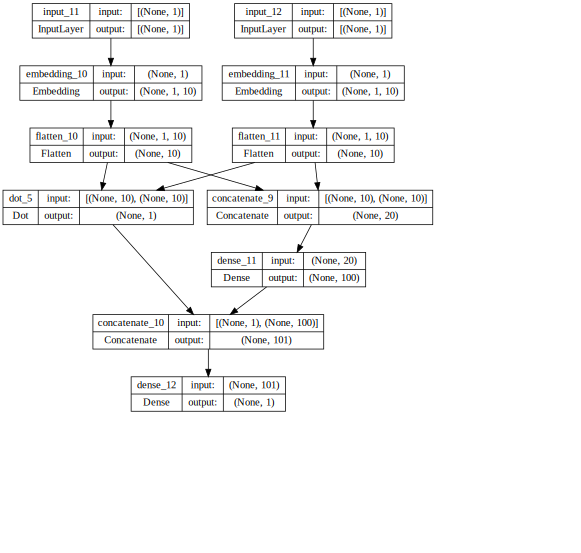

In [42]:
SVG(model_to_dot(NMF_model, show_shapes=True).create(prog='dot', format='svg'))

In [43]:
path_checkpt = "NMF_checkpt.h5"
es_callback = EarlyStopping(monitor="val_rmse", patience=5)

modelckpt_callback = ModelCheckpoint(
    monitor="val_rmse",
    filepath=path_checkpt,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

In [44]:
history = NMF_model.fit(X_tr, y_tr, validation_data=(X_te, y_te), batch_size =128, epochs=40, callbacks=[es_callback, modelckpt_callback])  

Epoch 1/40
631/631 [==============================] - ETA: 0s - loss: 2.0624 - rmse: 1.4361
Epoch 1: val_rmse improved from inf to 0.88573, saving model to NMF_checkpt.h5
631/631 [==============================] - 9s 13ms/step - loss: 2.0624 - rmse: 1.4361 - val_loss: 0.7845 - val_rmse: 0.8857
Epoch 2/40
631/631 [==============================] - ETA: 0s - loss: 0.7235 - rmse: 0.8506
Epoch 2: val_rmse improved from 0.88573 to 0.87412, saving model to NMF_checkpt.h5
631/631 [==============================] - 3s 5ms/step - loss: 0.7235 - rmse: 0.8506 - val_loss: 0.7641 - val_rmse: 0.8741
Epoch 3/40
631/631 [==============================] - ETA: 0s - loss: 0.6878 - rmse: 0.8293
Epoch 3: val_rmse improved from 0.87412 to 0.87269, saving model to NMF_checkpt.h5
631/631 [==============================] - 3s 5ms/step - loss: 0.6878 - rmse: 0.8293 - val_loss: 0.7616 - val_rmse: 0.8727
Epoch 4/40
624/631 [============================>.] - ETA: 0s - loss: 0.6670 - rmse: 0.8167
Epoch 4: val_rmse

In [45]:
pred = NMF_model.predict([df.userId, df.movieId])

2/2 [==============================] - 0s 4ms/step


In [47]:
df_pred = pd.concat([df, pd.DataFrame(pred, columns = ['pred_rating'])], axis = 1)
df_pred

,userId,movieId,rating,pred_rating
0,0,0,4.0,4.890238
1,0,1,4.0,4.370559
2,0,2,4.0,4.741462
3,0,5,3.0,4.583079
4,0,14,4.0,4.015114
5,0,16,3.0,4.888774
6,0,18,5.0,4.681599
7,0,31,5.0,4.599469
8,0,39,3.0,3.869068
9,0,42,3.0,4.544064
